#### Importing Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import textwrap


#### EDA on usecase_1_.csv

In [2]:
df = pd.read_csv(r'usecase_1_.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117980 entries, 0 to 117979
Data columns (total 32 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Unnamed: 0.1                117980 non-null  int64  
 1   Unnamed: 0                  117980 non-null  int64  
 2   NCT Number                  117980 non-null  object 
 3   Study Title                 117980 non-null  object 
 4   Study URL                   117980 non-null  object 
 5   Acronym                     24116 non-null   object 
 6   Study Status                117980 non-null  object 
 7   Brief Summary               117980 non-null  object 
 8   Study Results               117980 non-null  object 
 9   Conditions                  117950 non-null  object 
 10  Interventions               112324 non-null  object 
 11  Primary Outcome Measures    114903 non-null  object 
 12  Secondary Outcome Measures  93200 non-null   object 
 13  Other Outcome 

In [4]:
df.describe()

,Unnamed: 0.1,Unnamed: 0,Enrollment
count,117980.000000,117980.000000,1.161470e+05
mean,58989.500000,75024.005620,4.487728e+03
std,34058.036717,43318.321717,5.930507e+05
min,0.000000,1.000000,0.000000e+00
25%,29494.750000,37511.500000,3.000000e+01
50%,58989.500000,75004.500000,7.700000e+01
75%,88484.250000,112567.250000,2.420000e+02
max,117979.000000,150121.000000,1.888141e+08


##### Dropping Unnecessary Columns

Unnamed: 0.1 and Unnamed: 0 are just indexes so we dont need to have them since we already have an index

In [5]:
df.drop(columns = ["Unnamed: 0.1","Unnamed: 0"],inplace=True)

The Colums like Study URL, Start Date, Funder Type(Same), Primary Completion Date, Completion Date, First Posted, Reults First Posted, Last Update Posted, Other IDs, Study Status, Study Results, Collaborator, Study Documents are not suitable for using in Semantic Search so we will remove them.

In [6]:
admin_data = df[["NCT Number","Study URL", "Study Status", "Study Results", "Collaborators", "Funder Type", "Other IDs",
                 "Start Date", "Primary Completion Date", "Completion Date", "First Posted", "Results First Posted",
                 "Last Update Posted", "Study Documents"]]

df.drop(columns=["Study URL", "Study Status", "Study Results", "Collaborators", "Funder Type", "Other IDs",
                 "Start Date", "Primary Completion Date", "Completion Date", "First Posted", "Results First Posted",
                 "Last Update Posted", "Study Documents"],
        inplace=True)

In [7]:
print(df["Study Design"].dtype)

object


Separating Different Values of Study Design into Different Columns and creating a separate Dataframw for now.

In [8]:
def split_to_columns(row):
    if pd.isna(row):  # Check if the row is NaN
        return {}
    key_value_pairs = [item.split(': ', 1) for item in row.split('|') if ': ' in item]
    return {key.strip(): value.strip() for key, value in key_value_pairs}

studydes_df = pd.DataFrame(df['Study Design'].apply(split_to_columns).to_list())

studydes_df["NCT Number"] = df["NCT Number"]

In [9]:
def split_to_columns(row):
    if pd.isna(row):
        return {}

    result = {}
    for item in row.split('|'):
        try:
            key, value = item.split(':')
            if key in result:
                result[key] += f", {value.strip()}"
            else:
                result[key] = value.strip()
        except ValueError:
            # Handle rows without a colon (e.g., ignore or assign a default value)
            pass  # Ignore for now

    return result

# Apply the function to the 'Study Design' column
try:
    studydes_df = pd.DataFrame(df['Study Design'].apply(split_to_columns).to_list())
    studydes_df["NCT Number"] = df["NCT Number"]
except ValueError:
    # Handle potential errors during DataFrame creation
    pass  # Ignore for now

Converting the Masking Column into Masking Type, Maskings and [Masking1, Masking2, Maskking3, Masking4] and creating a column Masking Description (A Sentence that explains these Maskings)

In [10]:
def extract_masking_details(masking_str):
    if pd.isna(masking_str) or not masking_str.strip():
        return None, []
    else:
        if '(' in masking_str:
            masking_type = masking_str.split('(')[0].strip()
            maskings = masking_str.split('(')[1].strip(')')
            maskings = maskings.split(', ') if maskings else []
        else:
            masking_type = masking_str.strip()
            maskings = []
        
        return masking_type, maskings

studydes_df['Masking Type'] = studydes_df['Masking'].apply(lambda x: extract_masking_details(x)[0])
studydes_df['Maskings'] = studydes_df['Masking'].apply(lambda x: extract_masking_details(x)[1])

def separate_maskings(maskings):
    masking1 = maskings[0] if len(maskings) >= 1 else None
    masking2 = maskings[1] if len(maskings) >= 2 else None
    masking3 = maskings[2] if len(maskings) >= 3 else None
    masking4 = maskings[3] if len(maskings) >= 4 else None
    return masking1, masking2, masking3, masking4

studydes_df['Masking1'] = studydes_df['Maskings'].apply(lambda x: separate_maskings(x)[0])
studydes_df['Masking2'] = studydes_df['Maskings'].apply(lambda x: separate_maskings(x)[1])
studydes_df['Masking3'] = studydes_df['Maskings'].apply(lambda x: separate_maskings(x)[2])
studydes_df['Masking4'] = studydes_df['Maskings'].apply(lambda x: separate_maskings(x)[3])

def create_masking_description(masking_type, maskings):
    if masking_type == "NONE":
        return "None"
    else:
        if not maskings:
            return f"The masking is of type {masking_type}"
        else:
            maskings_str = ", ".join(maskings[:-1]) + " and " + maskings[-1]
            return f"The masking is of type {masking_type} which includes {maskings_str}"

studydes_df['Masking Description'] = studydes_df.apply(lambda row: create_masking_description(row['Masking Type'], row['Maskings']), axis=1)

In [11]:
studydes_df.head()

,Allocation,Intervention Model,Masking,Primary Purpose,Observational Model,Time Perspective,NCT Number,Masking Type,Maskings,Masking1,Masking2,Masking3,Masking4,Masking Description
0,NON_RANDOMIZED,PARALLEL,NONE,TREATMENT,NaN,NaN,NCT03302091,NONE,[],None,None,None,None,None
1,NA,SINGLE_GROUP,NONE,TREATMENT,NaN,NaN,NCT01948791,NONE,[],None,None,None,None,None
2,NA,SINGLE_GROUP,NONE,OTHER,NaN,NaN,NCT04621591,NONE,[],None,None,None,None,None
3,NA,SINGLE_GROUP,NONE,OTHER,NaN,NaN,NCT03130491,NONE,[],None,None,None,None,None
4,RANDOMIZED,PARALLEL,"DOUBLE (PARTICIPANT, INVESTIGATOR)",TREATMENT,NaN,NaN,NCT01580891,DOUBLE,"[PARTICIPANT, INVESTIGATOR]",PARTICIPANT,INVESTIGATOR,None,None,The masking is of type DOUBLE which includes P...


Separating The values in the Interventions Column into different Columns and creating a separate Dataframe as of now.

In [12]:
def split_to_columns(row):
    if pd.isna(row):
        return {}

    result = {}
    for item in row.split('|'):
        try:
            key, value = item.split(':')
            if key in result:
                result[key] += f", {value.strip()}"
            else:
                result[key] = value.strip()
        except ValueError:
            # Handle rows without a colon (e.g., ignore or assign a default value)
            pass  # Ignore for now

    return result

# Apply the function to the 'Interventions' column
try:
    interventions_df = pd.DataFrame(df['Interventions'].apply(split_to_columns).to_list())
    interventions_df['NCT Number'] = df['NCT Number']
except ValueError:
    # Handle potential errors during DataFrame creation
    pass  # Ignore for now

In [13]:
interventions_df.isna().sum()

DRUG                    42755
DEVICE                  99845
PROCEDURE              115759
BIOLOGICAL             106619
OTHER                  108677
COMBINATION_PRODUCT    117318
BEHAVIORAL             117128
DIETARY_SUPPLEMENT     115691
GENETIC                117574
DIAGNOSTIC_TEST        116939
RADIATION              117545
NCT Number                  0
dtype: int64

In [14]:
new_column_names = ['Drug', 'Device', 'Procedure', 'Biological', 'Other', 'Combination Product', 'Behavioral',
                   'Dietary Supplement', 'Genetic', 'Diaganostic Test', 'Radiation', 'NCT Number']

interventions_df.columns = new_column_names

Converting the Conditions Column into Sentences for Better Semanting

In [15]:
df['Conditions'] = df['Conditions'].str.replace('|', ' and ')

print(df["Conditions"])

0                           Renal Insufficiency and Healthy
1                                       Alzheimer's Disease
2                                             EGD Procedure
3                                      Aortic Valve Disease
4                                               Tinea Pedis
                                ...                        
117975                                        Schizophrenia
117976            Hepatic Impairment and Healthy Volunteers
117977     Diagnosis and Gonorrhea and Resistance Bacterial
117978                       Pain and Peripheral Neuropathy
117979    Progressive Familial Intrahepatic Cholestasis ...
Name: Conditions, Length: 117980, dtype: object


Converting the Age Column to Sentences

In [16]:
df['Age'] = df['Age'].str.replace(',', ' and ')

print(df["Age"])

0         ADULT and  OLDER_ADULT
1         ADULT and  OLDER_ADULT
2         ADULT and  OLDER_ADULT
3         ADULT and  OLDER_ADULT
4         ADULT and  OLDER_ADULT
                   ...          
117975                     ADULT
117976    ADULT and  OLDER_ADULT
117977    ADULT and  OLDER_ADULT
117978    ADULT and  OLDER_ADULT
117979          CHILD and  ADULT
Name: Age, Length: 117980, dtype: object


Rewriting the Unique Values of the Phase Column

In [17]:
replacements = {
    'PHASE1': '1st Phase',
    'PHASE2': '2nd Phase',
    'PHASE3': '3rd Phase',
    'PHASE4': '4th Phase',
    'PHASE1|PHASE2': '1st Phase and 2nd Phase',
    'PHASE2|PHASE3': '2nd Phase and 3rd Phase',
    'EARLY_PHASE1': 'Early 1st Phase',
    '|': ' and '
}

df['Phases'] = df['Phases'].replace(replacements, regex=False)

In [18]:
df["Phases"].value_counts()

Phases
1st Phase                  26771
3rd Phase                  21161
2nd Phase                  20501
4th Phase                   6930
1st Phase and 2nd Phase     5617
2nd Phase and 3rd Phase     1600
Early 1st Phase              515
Name: count, dtype: int64

The Enrollment Column EDA

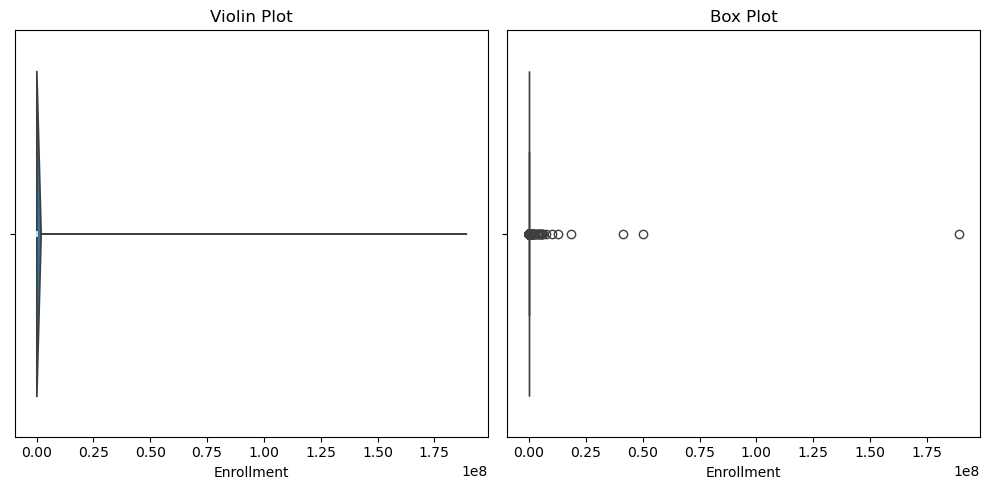

In [19]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
sns.violinplot(data=df, x="Enrollment", orient='h')
plt.title('Violin Plot')

plt.subplot(1, 2, 2)
sns.boxplot(data=df, x="Enrollment", orient='h')
plt.title('Box Plot')

plt.tight_layout()
plt.show()

The Enrollment Column is too skewed as of now and i dont know how to deal with it. So i am not using it as of now.

In [20]:
admin_data["Enrollment"] = df["Enrollment"]

df.drop(columns = ["Enrollment"], inplace = True)

C:\Users\dheer\AppData\Local\Temp\ipykernel_9652\2699840150.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  admin_data["Enrollment"] = df["Enrollment"]


Correcting the Study Type Column

In [21]:
df['Study Type'] = df['Study Type'].replace('EXPANDED_ACCESS', 'EXPANDED ACCESS')

The Locations Column contains too much data and i am yet to discover a good enough way to preprocess it so will not be using it in initial stages.

In [22]:
admin_data["Locations"] = df["Locations"]

df.drop(columns = ["Locations"], inplace = True)


In [23]:
df

,NCT Number,Study Title,Acronym,Brief Summary,Conditions,Interventions,Primary Outcome Measures,Secondary Outcome Measures,Other Outcome Measures,Sponsor,Sex,Age,Phases,Study Type,Study Design
0,NCT03302091,A Study in People With Normal Kidney Function ...,NaN,The primary objective of the current study is ...,Renal Insufficiency and Healthy,DRUG: BI 1467335,Area Under the Concentration-time Curve of BI ...,Area Under the Concentration-time Curve of BI ...,NaN,Boehringer Ingelheim,ALL,ADULT and OLDER_ADULT,1st Phase,INTERVENTIONAL,Allocation: NON_RANDOMIZED|Intervention Model:...
1,NCT01948791,16w Interventional Study on Titration and Dose...,INSTINCT,To investigate the efficacy of Exelon capsule ...,Alzheimer's Disease,DRUG: ENA713,Mean Change From Baseline in the Alzheimer's D...,Change From Baseline in the Alzheimer's Diseas...,NaN,Novartis Pharmaceuticals,ALL,ADULT and OLDER_ADULT,4th Phase,INTERVENTIONAL,Allocation: NA|Intervention Model: SINGLE_GROU...
2,NCT04621591,Case Series With Saneso 360° Gastroscope,NaN,To confirm the procedural performance of the S...,EGD Procedure,DEVICE: Saneso 360° gastroscope,"Successful EGD, Procedure success is assessed ...",Endoscopist qualitative rating of the Saneso 3...,NaN,Saneso Inc.,ALL,ADULT and OLDER_ADULT,NaN,INTERVENTIONAL,Allocation: NA|Intervention Model: SINGLE_GROU...
3,NCT03130491,European Study Evaluating the EMBLOK Embolic P...,NaN,The primary objective is to evaluate the perfo...,Aortic Valve Disease,PROCEDURE: Transcatheter Aortic Valve Replacem...,"Performance Endpoint, successful insertion, pl...","Safety Endpoint (Rate of MACCE), Rate of MACCE...","Efficacy Endpoint, Reduction in embolic burden...",Innovative Cardiovascular Solutions,ALL,ADULT and OLDER_ADULT,NaN,INTERVENTIONAL,Allocation: NA|Intervention Model: SINGLE_GROU...
4,NCT01580891,Evaluate the Clinical Equivalence of Two Nafti...,NaN,The objective of this study is to evaluate the...,Tinea Pedis,DRUG: Naftifine HCl Cream 1%|DRUG: Naftin® (Na...,"Therapeutic Cure, Patients with both mycologic...",NaN,NaN,Taro Pharmaceuticals USA,ALL,ADULT and OLDER_ADULT,1st Phase,INTERVENTIONAL,Allocation: RANDOMIZED|Intervention Model: PAR...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117975,NCT00706654,Intramuscular Depot Formulation of Aripiprazol...,ASPIRE,The purpose of the this trial is to evaluate t...,Schizophrenia,DRUG: Aripiprazole depot 300 or 400 mg|DRUG: A...,Percentage of Patients Meeting Exacerbation of...,Time to Exacerbation of Psychotic Symptoms/Imp...,NaN,Otsuka Pharmaceutical Development & Commercial...,ALL,ADULT,3rd Phase,INTERVENTIONAL,Allocation: RANDOMIZED|Intervention Model: PAR...
117976,NCT05098054,A Study of Soticlestat in Adults With Liver Fa...,NaN,The main aim is to check the effect of a singl...,Hepatic Impairment and Healthy Volunteers,DRUG: Soticlestat,Cmax: Maximum Observed Plasma Concentration fo...,Number of Participants Reporting One or More T...,NaN,Takeda,ALL,ADULT and OLDER_ADULT,1st Phase,INTERVENTIONAL,Allocation: NON_RANDOMIZED|Intervention Model:...
117977,NCT06352554,Susceptibility Testing In Neisseria Gonorrhoea...,STING,This study aims to validate a novel antibiotic...,Diagnosis and Gonorrhea and Resistance Bacterial,NaN,To determine the feasibility of performing ant...,To study the performance of the InSignia assay...,NaN,SpeeDx Pty Ltd,ALL,ADULT and OLDER_ADULT,NaN,OBSERVATIONAL,Observational Model: |Time Perspective: p
117978,NCT00710554,A Study of Sativex® for Pain Relief of Periphe...,NaN,The purpose of this study is to evaluate the e...,Pain and Peripheral Neuropathy,DRUG: Sativex|DRUG: Placebo,Change From Baseline in Mean Peripheral Neurop...,Change From Baseline in Neuropathic Pain Scale...,NaN,Jazz Pharmaceuticals,ALL,ADULT and OLDER_ADULT,3rd Phase,INTERVENTIONAL,Allocation: RANDOMIZED|Intervention Model: PAR...


#### EDA on eligibilities.txt

The Code for Converting Eligibilities.txt to a CSV

```python
import csv

input_file_path = r'D:\675ad747652b5_problem_statements_and_data_sets\Problem Statements and Data Sets\eligibilities.txt'  # Replace with your text file path
output_file_path = r'D:\eligibilities.csv'  # Replace with desired output CSV file path

with open(input_file_path, 'r', encoding='utf-8', errors='ignore') as txt_file:
    with open(output_file_path, 'w', newline='', encoding='utf-8') as csv_file:
        # Create a CSV writer with the '|' delimiter
        csv_writer = csv.writer(csv_file, delimiter=',')  # Default CSV separator is ","
        
        # Read each line from the text file
        for line in txt_file:
            # Split the line using '|' as the separator
            columns = line.strip().split('|')
            
            # Write the columns to the CSV file
            csv_writer.writerow(columns)

print("File has been successfully converted to CSV!")
```

Code Used to print the txt file

```python
with open(r'D:\675ad747652b5_problem_statements_and_data_sets\Problem Statements and Data Sets\eligibilities.txt', encoding='utf-8', errors='ignore') as file:
    for line in file:
        print(line.strip())  
```

In [24]:
elig = pd.read_csv('eligibilities.csv', on_bad_lines='skip')


In [25]:
elig.head()

,id,nct_id,sampling_method,gender,minimum_age,maximum_age,healthy_volunteers,population,criteria,gender_description,gender_based,adult,child,older_adult
0,6260055,NCT05050916,NaN,FEMALE,19 Years,40 Years,f,NaN,"""* INCLUSION CRITERIA:~In order to be eligible...",NaN,NaN,t,f,f
1,6260056,NCT01092156,NaN,FEMALE,18 Years,NaN,t,NaN,"""Inclusion Criteria:~* Pregnant women who inte...",NaN,NaN,t,f,t
2,6260057,NCT01218256,NaN,ALL,30 Years,80 Years,f,NaN,"""Inclusion Criteria:~* type 2 diabetes mellitu...",NaN,NaN,t,f,t
3,6260058,NCT03240432,NaN,ALL,60 Years,NaN,t,NaN,"""Inclusion Criteria:~To be eligible for the st...",NaN,NaN,t,f,t
4,6260059,NCT04348578,NaN,ALL,18 Years,65 Years,t,NaN,"""Inclusion Criteria:~* necrotic, single root t...",NaN,NaN,t,f,t


##### Visulizing the Criteria Column of the Dataframe

In [26]:
wrapped_text = textwrap.fill(elig["criteria"][9], width=80)
print(wrapped_text)

"Inclusion Criteria:~* Patients must have a histologic diagnosis of
adenocarcinoma of the esophagus, or gastroesophageal junction based on biopsy
material or adequate cytologic exam.~* Patients must have incurable metastatic
or recurrent adenocarcinoma of esophagus or gastroesophageal junction.~*
Patients must have an ECOG performance status of 0-1.~* Patients must have
adequate bone marrow function as evidence by: absolute neutrophil count \>
1500/uL, and platelet count \> 100,000/uL~* Patients must have adequate renal
function as evidenced by a Cockcroft-Gault calculated creatinine clearance \> 30
mL/min.~* Patient must have adequate hepatic function as evidenced by: serum
total bilirubin \< 2.0 mg/dl, and AST/ALT \< 3 X the institutional upper limit
of normal. Patients with an elevated unconjugated bilirubin (Gilbert's syndrome)
will be eligible if hepatic enzymes and function are otherwise completely normal
(AST/ALT/Alk Phos within normal limits), and there is no evidence of
hemoly

Separating Criteria Column into Inclusion Criteria and Exclusion Criteria and cleaning the Data

In [27]:
import re

def extract_criteria(text):
    if pd.isna(text):
        return None, None
    
    inclusion_pattern = r"Inclusion Criteria:\s*(.*?)(?=Exclusion Criteria:|End of text)"
    exclusion_pattern = r"Exclusion Criteria:\s*(.*)"

    inclusion_match = re.search(inclusion_pattern, text, re.DOTALL)
    exclusion_match = re.search(exclusion_pattern, text, re.DOTALL)

    inclusion_criteria = inclusion_match.group(1).strip() if inclusion_match else None
    exclusion_criteria = exclusion_match.group(1).strip() if exclusion_match else None

    return inclusion_criteria, exclusion_criteria

# Assuming your DataFrame is named 'df' and the column with criteria is 'Criteria'
elig['Inclusion Criteria'] = elig['criteria'].apply(lambda x: extract_criteria(x)[0])
elig['Exclusion Criteria'] = elig['criteria'].apply(lambda x: extract_criteria(x)[1])

# Clean the text (optional, adjust as needed)
def clean_text(text):
    if pd.isna(text):
        return text
    
    # Remove extra spaces and newlines
    text = re.sub(r'\s+', ' ', text)
    # Remove specific symbols or characters (adjust as needed)
    text = re.sub(r'[~*]', '', text)
    return text

elig['Inclusion Criteria'] = elig['Inclusion Criteria'].apply(clean_text)
elig['Exclusion Criteria'] = elig['Exclusion Criteria'].apply(clean_text)

In [28]:
elig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 502245 entries, 0 to 502244
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   id                  502245 non-null  int64 
 1   nct_id              502245 non-null  object
 2   sampling_method     111494 non-null  object
 3   gender              501814 non-null  object
 4   minimum_age         469345 non-null  object
 5   maximum_age         266159 non-null  object
 6   healthy_volunteers  489522 non-null  object
 7   population          111482 non-null  object
 8   criteria            502154 non-null  object
 9   gender_description  9252 non-null    object
 10  gender_based        13898 non-null   object
 11  adult               502245 non-null  object
 12  child               502245 non-null  object
 13  older_adult         502245 non-null  object
 14  Inclusion Criteria  448773 non-null  object
 15  Exclusion Criteria  452843 non-null  object
dtypes:

Checking the Criteria Columns

In [29]:
index = 9

wrapped_text = textwrap.fill(elig["criteria"][index], width=80)
print(wrapped_text)

print(">>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>")

wrapped_text = textwrap.fill(elig["Inclusion Criteria"][index], width=80)
print(wrapped_text)

print(">>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>")

wrapped_text = textwrap.fill(elig["Exclusion Criteria"][index], width=80)
print(wrapped_text)

"Inclusion Criteria:~* Patients must have a histologic diagnosis of
adenocarcinoma of the esophagus, or gastroesophageal junction based on biopsy
material or adequate cytologic exam.~* Patients must have incurable metastatic
or recurrent adenocarcinoma of esophagus or gastroesophageal junction.~*
Patients must have an ECOG performance status of 0-1.~* Patients must have
adequate bone marrow function as evidence by: absolute neutrophil count \>
1500/uL, and platelet count \> 100,000/uL~* Patients must have adequate renal
function as evidenced by a Cockcroft-Gault calculated creatinine clearance \> 30
mL/min.~* Patient must have adequate hepatic function as evidenced by: serum
total bilirubin \< 2.0 mg/dl, and AST/ALT \< 3 X the institutional upper limit
of normal. Patients with an elevated unconjugated bilirubin (Gilbert's syndrome)
will be eligible if hepatic enzymes and function are otherwise completely normal
(AST/ALT/Alk Phos within normal limits), and there is no evidence of
hemoly

##### Replacing some values of columns to more sensible Values

Sampling Method

In [30]:
elig["sampling_method"].value_counts()

sampling_method
NON_PROBABILITY_SAMPLE    80172
PROBABILITY_SAMPLE        31322
Name: count, dtype: int64

In [31]:
replacements = {
    'NON_PROBABILITY_SAMPLE': 'Non Probability Sample',
    'PROBABILITY_SAMPLE': 'Probability Sample'
}

elig['sampling_method'] = elig['sampling_method'].replace(replacements, regex=False)

Healthy Volunteers

In [32]:
replacements = {
    'f': 'No',
    't': 'Yes'
}

elig['healthy_volunteers'] = elig['healthy_volunteers'].replace(replacements, regex=False)

In [33]:
elig["healthy_volunteers"].value_counts()

healthy_volunteers
No     355670
Yes    133852
Name: count, dtype: int64

Gender Based

In [34]:
replacements = {
    'f': 'No',
    't': 'Yes'
}

elig['gender_based'] = elig['gender_based'].replace(replacements, regex=False)

elig["gender_based"].value_counts()

gender_based
Yes    13898
Name: count, dtype: int64

Adult

In [35]:
replacements = {
    'f': 'No',
    't': 'Yes'
}

elig['adult'] = elig['adult'].replace(replacements, regex=False)

elig["adult"].value_counts()

adult
Yes    464223
No      38022
Name: count, dtype: int64

Child

In [36]:
replacements = {
    'f': 'No',
    't': 'Yes'
}

elig['child'] = elig['child'].replace(replacements, regex=False)

elig["child"].value_counts()

child
No     403811
Yes     98434
Name: count, dtype: int64

Older Adult

In [37]:
replacements = {
    'f': 'No',
    't': 'Yes'
}

elig['older_adult'] = elig['older_adult'].replace(replacements, regex=False)

elig["older_adult"].value_counts()

older_adult
Yes    383250
No     118995
Name: count, dtype: int64

In [38]:
new_column_names = ['id', 'NCT Number', 'Sampling Method', 'Gender', 'Minimum Age', 'Maximum Age', 'Healthy Volunteers',
                   'Population', 'Criteria', 'Gender Description', 'Gender Based', 'Adult', 'Child', 'Older Adult',
                   'Inclusion Criteria', 'Exclusion Criteria']

elig.columns = new_column_names

In [39]:
elig.drop(columns=["id"],inplace=True)

#### Joining all the Dataframes

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117980 entries, 0 to 117979
Data columns (total 15 columns):
 #   Column                      Non-Null Count   Dtype 
---  ------                      --------------   ----- 
 0   NCT Number                  117980 non-null  object
 1   Study Title                 117980 non-null  object
 2   Acronym                     24116 non-null   object
 3   Brief Summary               117980 non-null  object
 4   Conditions                  117950 non-null  object
 5   Interventions               112324 non-null  object
 6   Primary Outcome Measures    114903 non-null  object
 7   Secondary Outcome Measures  93200 non-null   object
 8   Other Outcome Measures      7924 non-null    object
 9   Sponsor                     117980 non-null  object
 10  Sex                         117838 non-null  object
 11  Age                         117980 non-null  object
 12  Phases                      83095 non-null   object
 13  Study Type                  1

In [41]:
studydes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117980 entries, 0 to 117979
Data columns (total 14 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   Allocation           101198 non-null  object
 1   Intervention Model   101198 non-null  object
 2   Masking              101198 non-null  object
 3   Primary Purpose      101198 non-null  object
 4   Observational Model  16130 non-null   object
 5   Time Perspective     16130 non-null   object
 6   NCT Number           117980 non-null  object
 7   Masking Type         100223 non-null  object
 8   Maskings             117980 non-null  object
 9   Masking1             41333 non-null   object
 10  Masking2             36202 non-null   object
 11  Masking3             22513 non-null   object
 12  Masking4             15489 non-null   object
 13  Masking Description  117980 non-null  object
dtypes: object(14)
memory usage: 12.6+ MB


In [42]:
interventions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117980 entries, 0 to 117979
Data columns (total 12 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   Drug                 75225 non-null   object
 1   Device               18135 non-null   object
 2   Procedure            2221 non-null    object
 3   Biological           11361 non-null   object
 4   Other                9303 non-null    object
 5   Combination Product  662 non-null     object
 6   Behavioral           852 non-null     object
 7   Dietary Supplement   2289 non-null    object
 8   Genetic              406 non-null     object
 9   Diaganostic Test     1041 non-null    object
 10  Radiation            435 non-null     object
 11  NCT Number           117980 non-null  object
dtypes: object(12)
memory usage: 10.8+ MB


In [43]:
elig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 502245 entries, 0 to 502244
Data columns (total 15 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   NCT Number          502245 non-null  object
 1   Sampling Method     111494 non-null  object
 2   Gender              501814 non-null  object
 3   Minimum Age         469345 non-null  object
 4   Maximum Age         266159 non-null  object
 5   Healthy Volunteers  489522 non-null  object
 6   Population          111482 non-null  object
 7   Criteria            502154 non-null  object
 8   Gender Description  9252 non-null    object
 9   Gender Based        13898 non-null   object
 10  Adult               502245 non-null  object
 11  Child               502245 non-null  object
 12  Older Adult         502245 non-null  object
 13  Inclusion Criteria  448773 non-null  object
 14  Exclusion Criteria  452843 non-null  object
dtypes: object(15)
memory usage: 57.5+ MB


In [44]:
merged_df = df.merge(studydes_df, on='NCT Number') \
               .merge(interventions_df, on='NCT Number') \
               .merge(elig, on='NCT Number')

In [45]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116149 entries, 0 to 116148
Data columns (total 53 columns):
 #   Column                      Non-Null Count   Dtype 
---  ------                      --------------   ----- 
 0   NCT Number                  116149 non-null  object
 1   Study Title                 116149 non-null  object
 2   Acronym                     23677 non-null   object
 3   Brief Summary               116149 non-null  object
 4   Conditions                  116120 non-null  object
 5   Interventions               110576 non-null  object
 6   Primary Outcome Measures    113082 non-null  object
 7   Secondary Outcome Measures  91742 non-null   object
 8   Other Outcome Measures      7734 non-null    object
 9   Sponsor                     116149 non-null  object
 10  Sex                         116008 non-null  object
 11  Age                         116149 non-null  object
 12  Phases                      81968 non-null   object
 13  Study Type                  1

#### Handling NaN/None Values

In [46]:
print(merged_df["Acronym"].isna().sum())

92472


In [47]:
merged_df["Acronym"] = merged_df["Acronym"].fillna("Not Available")

In [48]:
print(merged_df["Conditions"].isna().sum())

29


In [49]:
merged_df["Conditions"] = merged_df["Conditions"].fillna("Not Available")

In [50]:
print(merged_df["Interventions"].isna().sum())

5573


In [51]:
merged_df["Interventions"] = merged_df["Interventions"].fillna("Not Available")

In [52]:
print(merged_df["Primary Outcome Measures"].isna().sum())

3067


In [53]:
merged_df["Primary Outcome Measures"] = merged_df["Primary Outcome Measures"].fillna("Not Available")

In [54]:
print(merged_df["Other Outcome Measures"].isna().sum())

108415


In [55]:
merged_df["Other Outcome Measures"] = merged_df["Other Outcome Measures"].fillna("Not Available")

In [56]:
print(merged_df["Secondary Outcome Measures"].isna().sum())

24407


In [57]:
merged_df["Secondary Outcome Measures"] = merged_df["Secondary Outcome Measures"].fillna("Not Available")

In [58]:
print(merged_df["Sex"].isna().sum())

141


In [59]:
merged_df["Sex"] = merged_df["Sex"].fillna("all")

In [60]:
print(merged_df["Phases"].isna().sum())

34181


In [61]:
merged_df["Phases"] = merged_df["Phases"].fillna("Not Available")

In [62]:
print(merged_df["Study Design"].isna().sum())

642


In [63]:
merged_df["Study Design"] = merged_df["Study Design"].fillna("Not Available")

In [64]:
merged_df["Allocation"].value_counts()

Allocation
RANDOMIZED        61572
NA                22627
NON_RANDOMIZED    14100
                   1364
Name: count, dtype: int64

In [65]:
merged_df["Allocation"] = merged_df["Allocation"].replace(['NA', '', 'N/A'], np.nan)
print(merged_df["Allocation"].isna().sum())

40477


In [66]:
merged_df["Allocation"] = merged_df["Allocation"].fillna("Not Available")

In [67]:
merged_df["Intervention Model"].value_counts()

Intervention Model
PARALLEL        51967
SINGLE_GROUP    29450
CROSSOVER       10978
SEQUENTIAL       5471
                 1376
FACTORIAL         421
Name: count, dtype: int64

In [68]:
merged_df["Intervention Model"] = merged_df["Intervention Model"].replace(['NA', '', 'N/A'], np.nan)
print(merged_df["Intervention Model"].isna().sum())

17862


In [69]:
merged_df["Intervention Model"] = merged_df["Intervention Model"].fillna("Other")

In [70]:
merged_df["Masking"].value_counts()

Masking
NONE                                                                       54333
QUADRUPLE (PARTICIPANT, CARE_PROVIDER, INVESTIGATOR, OUTCOMES_ASSESSOR)    15217
DOUBLE (PARTICIPANT, INVESTIGATOR)                                         12132
TRIPLE (PARTICIPANT, CARE_PROVIDER, INVESTIGATOR)                           3787
DOUBLE                                                                      3372
TRIPLE (PARTICIPANT, INVESTIGATOR, OUTCOMES_ASSESSOR)                       2897
SINGLE (PARTICIPANT)                                                        2648
SINGLE (OUTCOMES_ASSESSOR)                                                  1652
                                                                             975
DOUBLE (PARTICIPANT, OUTCOMES_ASSESSOR)                                      834
SINGLE (INVESTIGATOR)                                                        689
DOUBLE (PARTICIPANT, CARE_PROVIDER)                                          318
SINGLE              

In [71]:
merged_df["Masking"] = merged_df["Masking"].replace(['NA', '', 'N/A','NONE'], np.nan)
print(merged_df["Masking"].isna().sum())

71794


In [72]:
merged_df["Masking"] = merged_df["Masking"].fillna("Other")

In [73]:
merged_df["Primary Purpose"].value_counts()

Primary Purpose
TREATMENT                   76872
PREVENTION                   6211
OTHER                        4997
BASIC_SCIENCE                4371
                             2578
DIAGNOSTIC                   2084
SUPPORTIVE_CARE              1463
DEVICE_FEASIBILITY            424
HEALTH_SERVICES_RESEARCH      327
SCREENING                     317
ECT                            19
Name: count, dtype: int64

In [74]:
merged_df["Primary Purpose"] = merged_df["Primary Purpose"].replace(['NA', '', 'N/A','NONE'], np.nan)
print(merged_df["Primary Purpose"].isna().sum())

19064


In [75]:
merged_df["Primary Purpose"] = merged_df["Primary Purpose"].fillna("OTHER")

In [76]:
merged_df["Observational Model"].value_counts()

Observational Model
    15844
Name: count, dtype: int64

In [77]:
merged_df["Observational Model"] = merged_df["Observational Model"].replace(['NA', '', 'N/A','NONE'], np.nan)
print(merged_df["Observational Model"].isna().sum())

116149


C:\Users\dheer\AppData\Local\Temp\ipykernel_9652\1773635635.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merged_df["Observational Model"] = merged_df["Observational Model"].replace(['NA', '', 'N/A','NONE'], np.nan)


In [78]:
merged_df.drop(columns="Observational Model", inplace=True)

In [79]:
merged_df["Time Perspective"].value_counts()

Time Perspective
p    15844
Name: count, dtype: int64

In [80]:
col = "Time Perspective"
merged_df[col] = merged_df[col].replace(['NA', '', 'N/A','NONE'], np.nan)
print(merged_df[col].isna().sum())

100305


In [81]:
col = "Time Perspective"
merged_df[col] = merged_df[col].fillna("No Info")

In [82]:
merged_df["Masking Type"].value_counts()

Masking Type
NONE         54333
DOUBLE       16883
QUADRUPLE    15217
TRIPLE        6921
SINGLE        5334
Name: count, dtype: int64

In [83]:
col = "Masking Type"
merged_df[col] = merged_df[col].replace(['NA', '', 'N/A','NONE'], np.nan)
print(merged_df[col].isna().sum())

71794


In [84]:
col = "Masking Type"
merged_df[col] = merged_df[col].fillna("Other")

In [85]:
merged_df["Maskings"].value_counts()

Maskings
[]                                                               75448
[PARTICIPANT, CARE_PROVIDER, INVESTIGATOR, OUTCOMES_ASSESSOR]    15217
[PARTICIPANT, INVESTIGATOR]                                      12132
[PARTICIPANT, CARE_PROVIDER, INVESTIGATOR]                        3787
[PARTICIPANT, INVESTIGATOR, OUTCOMES_ASSESSOR]                    2897
[PARTICIPANT]                                                     2648
[OUTCOMES_ASSESSOR]                                               1652
[PARTICIPANT, OUTCOMES_ASSESSOR]                                   834
[INVESTIGATOR]                                                     689
[PARTICIPANT, CARE_PROVIDER]                                       318
[PARTICIPANT, CARE_PROVIDER, OUTCOMES_ASSESSOR]                    195
[INVESTIGATOR, OUTCOMES_ASSESSOR]                                  178
[CARE_PROVIDER]                                                     63
[CARE_PROVIDER, INVESTIGATOR, OUTCOMES_ASSESSOR]                    

Maskings Column is not to be used

In [86]:
merged_df["Masking1"].value_counts()

Masking1
PARTICIPANT          38028
OUTCOMES_ASSESSOR     1652
INVESTIGATOR           867
CARE_PROVIDER          154
Name: count, dtype: int64

In [87]:
col = "Masking1"
merged_df[col] = merged_df[col].replace(['NA', '', 'N/A','NONE'], np.nan)
print(merged_df[col].isna().sum())

75448


In [88]:
col = "Masking1"
merged_df[col] = merged_df[col].fillna("Other")

In [89]:
merged_df["Masking2"].value_counts()

Masking2
CARE_PROVIDER        19517
INVESTIGATOR         15104
OUTCOMES_ASSESSOR     1028
Name: count, dtype: int64

In [90]:
col = "Masking2"
merged_df[col] = merged_df[col].replace(['NA', '', 'N/A','NONE'], np.nan)
print(merged_df[col].isna().sum())

80500


In [91]:
col = "Masking1"
merged_df[col] = merged_df[col].fillna("None")

In [92]:
merged_df["Masking2"].value_counts()

Masking2
CARE_PROVIDER        19517
INVESTIGATOR         15104
OUTCOMES_ASSESSOR     1028
Name: count, dtype: int64

In [93]:
col = "Masking2"
merged_df[col] = merged_df[col].replace(['NA', '', 'N/A','NONE'], np.nan)
print(merged_df[col].isna().sum())

80500


In [94]:
col = "Masking2"
merged_df[col] = merged_df[col].fillna("None")

In [95]:
merged_df["Masking3"].value_counts()

Masking3
INVESTIGATOR         19004
OUTCOMES_ASSESSOR     3134
Name: count, dtype: int64

In [96]:
col = "Masking3"
merged_df[col] = merged_df[col].replace(['NA', '', 'N/A','NONE'], np.nan)
print(merged_df[col].isna().sum())

94011


In [97]:
col = "Masking3"
merged_df[col] = merged_df[col].fillna("None")

In [98]:
merged_df["Masking4"].value_counts()

Masking4
OUTCOMES_ASSESSOR    15217
Name: count, dtype: int64

In [99]:
col = "Masking4"
merged_df[col] = merged_df[col].replace(['NA', '', 'N/A','NONE'], np.nan)
print(merged_df[col].isna().sum())

100932


In [100]:
col = "Masking4"
merged_df[col] = merged_df[col].fillna("None")

In [101]:
merged_df["Masking Description"].value_counts()

Masking Description
None                                                                                                              54333
The masking is of type None                                                                                       17461
The masking is of type QUADRUPLE which includes PARTICIPANT, CARE_PROVIDER, INVESTIGATOR and OUTCOMES_ASSESSOR    15217
The masking is of type DOUBLE which includes PARTICIPANT and INVESTIGATOR                                         12132
The masking is of type TRIPLE which includes PARTICIPANT, CARE_PROVIDER and INVESTIGATOR                           3787
The masking is of type DOUBLE                                                                                      3372
The masking is of type TRIPLE which includes PARTICIPANT, INVESTIGATOR and OUTCOMES_ASSESSOR                       2897
The masking is of type SINGLE which includes  and PARTICIPANT                                                      2648
The masking is of ty

In [102]:
col = "Masking Description"
merged_df[col] = merged_df[col].replace(['NA', '', 'N/A','NONE','None','The masking is of type None'], np.nan)
print(merged_df[col].isna().sum())

71794


In [103]:
col = "Masking Description"
merged_df[col] = merged_df[col].fillna("There is no masking")

In [104]:
merged_df["Drug"].value_counts()

Drug
Placebo                                                                                                                                                            372
Etanercept                                                                                                                                                          49
topiramate                                                                                                                                                          42
epoetin alfa                                                                                                                                                        42
insulin detemir                                                                                                                                                     37
                                                                                                                                                                

In [105]:
col = "Drug"
merged_df[col] = merged_df[col].replace(['NA', '', 'N/A','NONE','None'], np.nan)
print(merged_df[col].isna().sum())

41938


In [106]:
col = "Drug"
merged_df[col] = merged_df[col].fillna("Other")

In [107]:
merged_df['Drug'] = merged_df['Drug'].str.replace(", ", " and ")

In [108]:
merged_df["Device"].value_counts()

Device
Ulthera System Treatment                                                                    14
SENSIMED Triggerfish                                                                        13
Deep Brain Stimulation                                                                      12
Nerivio                                                                                     11
The ZELTIQ System                                                                           11
                                                                                            ..
Non-slip Balloon Catheter of Shanghai MicroPort Rhythm, NSE Coronary Dilatation Catheter     1
Power Knee with bone anchored suspension, C-Leg, Rheo Knee XC                                1
Piranha Treatment                                                                            1
Investigational Toric Lens, PureVision Toric Lens                                            1
Injection of adipose derived cells into pen

In [109]:
col = "Device"
merged_df[col] = merged_df[col].replace(['NA', '', 'N/A','NONE','None'], np.nan)
print(merged_df[col].isna().sum())

98365


In [110]:
col = "Device"
merged_df[col] = merged_df[col].fillna("Other")

In [111]:
merged_df['Device'] = merged_df['Device'].str.replace(", ", " and ")

In [112]:
merged_df["Procedure"].value_counts()

Procedure
Surgery                                                                             33
Standard of Care                                                                    25
Cataract surgery                                                                    25
Blood sampling                                                                      25
Microfracture                                                                       23
                                                                                    ..
Initiatives to improve compliance                                                    1
PCI + Impella                                                                        1
Single Photon Emission Computed Tomography, Multidetector Computed Tomography        1
Microcannula Harvest Adipose Stroma, Sterile Normal Saline IV Deployment of cSVF     1
Lumbar Puncture, Blood Collection                                                    1
Name: count, Length: 1694, dtype:

In [113]:
col = "Procedure"
merged_df[col] = merged_df[col].replace(['NA', '', 'N/A','NONE','None'], np.nan)
print(merged_df[col].isna().sum())

113958


In [114]:
col = "Procedure"
merged_df[col] = merged_df[col].fillna("Other")

In [115]:
merged_df["Biological"].value_counts()

Biological
Pembrolizumab                                                                                                                  118
Nivolumab                                                                                                                       41
Botulinum toxin type A                                                                                                          37
Nivolumab, Ipilimumab                                                                                                           33
botulinum toxin Type A                                                                                                          28
                                                                                                                              ... 
GSK Biologicals' HPV vaccine 580299, Merck's Human Papillomavirus Quadrivalent (Types 6, 11, 16, and 18) Vaccine (Gardasil)      1
Trastuzumab, Robatumumab, Cetuximab                                     

In [116]:
col = "Biological"
merged_df[col] = merged_df[col].replace(['NA', '', 'N/A','NONE','None'], np.nan)
print(merged_df[col].isna().sum())

104946


In [117]:
col = "Biological"
merged_df[col] = merged_df[col].fillna("Other")

In [118]:
merged_df["Other"].value_counts()

Other
Placebo                                                     2141
placebo                                                      148
No intervention                                              134
No Intervention                                              134
Standard of Care                                              82
                                                            ... 
Diagnostic test (LDT)                                          1
Interventions with heart failure medications                   1
Study formula feeding, Human milk feeding, Mixed feeding       1
Metformin GSK 850mg, Gluocophage 850mg                         1
Placebo, Sham Procedure                                        1
Name: count, Length: 5090, dtype: int64

In [119]:
col = "Other"
merged_df[col] = merged_df[col].replace(['NA', '', 'N/A','NONE','None'], np.nan)
print(merged_df[col].isna().sum())

107032


In [121]:
merged_df['Other'] = merged_df['Other'].str.replace(", ", " and ")

In [120]:
col = "Other"
merged_df[col] = merged_df[col].fillna("None")

In [122]:
merged_df["Combination Product"].value_counts()

Combination Product
LUM Imaging System                                                      5
VIOME Precision Nutrition Program                                       5
Pembrolizumab                                                           4
Testosterone enanthate auto-injector                                    4
NTX-001                                                                 3
                                                                       ..
Tymbion Iontophoresis and Tube Delivery System (TDS)                    1
CABA                                                                    1
VP-102 and applicator, Placebo                                          1
Omeza collagen matrix, Omeza lidocaine lavage, Omeza skin protectant    1
LINFU™ Technique                                                        1
Name: count, Length: 591, dtype: int64

In [123]:
col = "Combination Product"
merged_df[col] = merged_df[col].replace(['NA', '', 'N/A','NONE','None'], np.nan)
print(merged_df[col].isna().sum())

115502


In [125]:
merged_df['Combination Product'] = merged_df['Combination Product'].str.replace(", ", " and ")

In [124]:
col = "Combination Product"
merged_df[col] = merged_df[col].fillna("None")

In [126]:
merged_df["Behavioral"].value_counts()

Behavioral
Therapy                                                                                                                                                                   12
Psychotherapy                                                                                                                                                              9
Disease Management Assessment                                                                                                                                              6
Carevive CPS                                                                                                                                                               5
Behavioral support                                                                                                                                                         4
                                                                                                                            

In [127]:
merged_df['Behavioral'] = merged_df['Behavioral'].str.replace(", ", " and ")

In [128]:
col = "Behavioral"
merged_df[col] = merged_df[col].replace(['NA', '', 'N/A','NONE','None'], np.nan)
print(merged_df[col].isna().sum())

115324


In [129]:
col = "Behavioral"
merged_df[col] = merged_df[col].fillna("None")

In [130]:
merged_df["Dietary Supplement"].value_counts()

Dietary Supplement
Probiotic, Placebo                                                                                26
Probiotic                                                                                         25
Vitamin B12, Folic Acid                                                                            8
Probiotics, Placebo                                                                                7
Calcium, Vitamin D                                                                                 6
                                                                                                  ..
follow on formula without probiotics, follow on formula with Lactobacillus salivarius CECT5713     1
dietary supplement, 1 tablet containing delayed release melatonin, zinc and lemon balm             1
Dietary supplement liquid shot beverage products                                                   1
Dynamine (methylliberine)                                               

In [131]:
merged_df['Dietary Supplement'] = merged_df['Dietary Supplement'].str.replace(", ", " and ")

In [132]:
col = "Dietary Supplement"
merged_df[col] = merged_df[col].replace(['NA', '', 'N/A','NONE','None'], np.nan)
print(merged_df[col].isna().sum())

113929


In [133]:
col = "Dietary Supplement"
merged_df[col] = merged_df[col].fillna("None")

In [134]:
merged_df["Genetic"].value_counts()

Genetic
delandistrogene moxeparvovec    6
SGT-53                          5
GS010                           4
FT-003                          4
OAV101                          4
                               ..
Alferminogene tadenovec         1
AAV9-hSyn1-miGRIK2              1
a mixed plasmid DNA (HB-110)    1
nula-cel Drug Product           1
SB-728-T                        1
Name: count, Length: 314, dtype: int64

In [135]:
merged_df['Genetic'] = merged_df['Genetic'].str.replace(", ", " and ")

In [136]:
col = "Genetic"
merged_df[col] = merged_df[col].replace(['NA', '', 'N/A','NONE','None'], np.nan)
print(merged_df[col].isna().sum())

115760


In [137]:
col = "Genetic"
merged_df[col] = merged_df[col].fillna("Other")

In [138]:
merged_df["Diaganostic Test"].value_counts()

Diaganostic Test
Quantra System                        15
Corus CAD (ASGES)                      8
Venepuncture, Fingerstick              4
therascreen® KRAS RGQ PCR Kit          4
KidneyIntelX                           4
                                      ..
BioROSA MAP test                       1
BIOZEK COVID-19 Antigen Rapid Test     1
Observation                            1
PGT-A                                  1
PGT-A, ERA Test                        1
Name: count, Length: 896, dtype: int64

In [139]:
merged_df['Diaganostic Test'] = merged_df['Diaganostic Test'].str.replace(", ", " and ")

In [140]:
col = "Diaganostic Test"
merged_df[col] = merged_df[col].replace(['NA', '', 'N/A','NONE','None'], np.nan)
print(merged_df[col].isna().sum())

115138


In [141]:
col = "Diaganostic Test"
merged_df[col] = merged_df[col].fillna("Other")

In [142]:
col = "Radiation"
merged_df[col].value_counts()

Radiation
Radiotherapy                                50
Radiation                                   23
Radiation Therapy                           18
radiation therapy                           11
Radiation therapy                            9
                                            ..
Electronic brachytherapy (Axxent System)     1
Stereotactic Radio-Surgery (SRS) therapy     1
Shexiang Baoxin pill（MUSKARDIA）, Placebo     1
indium In 111 folic acid                     1
Cone Beam Computed Tomography                1
Name: count, Length: 259, dtype: int64

In [143]:
merged_df[col] = merged_df[col].str.replace(", ", " and ")

In [144]:
merged_df[col] = merged_df[col].replace(['NA', '', 'N/A','NONE','None'], np.nan)
print(merged_df[col].isna().sum())

115721


In [145]:
merged_df[col] = merged_df[col].fillna("Other")

In [146]:
col = "Sampling Method"
merged_df[col].value_counts()

Sampling Method
Non Probability Sample    11659
Probability Sample         3984
Name: count, dtype: int64

In [147]:
merged_df[col] = merged_df[col].replace(['NA', '', 'N/A','NONE','None'], np.nan)
print(merged_df[col].isna().sum())

100506


In [148]:
merged_df[col] = merged_df[col].fillna("Other")

In [149]:
col = "Gender"
merged_df[col].value_counts()

Gender
ALL       102366
MALE        7019
FEMALE      6623
Name: count, dtype: int64

In [150]:
merged_df[col] = merged_df[col].replace(['NA', '', 'N/A','NONE','None'], np.nan)
print(merged_df[col].isna().sum())

141


In [151]:
merged_df[col] = merged_df[col].fillna("ALL")

In [152]:
col = "Minimum Age"
merged_df[col].value_counts()

Minimum Age
18 Years     79274
20 Years      4513
40 Years      2750
19 Years      2235
21 Years      2218
             ...  
41 Months        1
140 Days         1
70 Days          1
49 Days          1
41 Days          1
Name: count, Length: 213, dtype: int64

In [153]:
def extract_age_in_years(age_str):
    try:
        if isinstance(age_str, str):  # Check if the input is a string
            if "Years" in age_str:
                return float(age_str.split()[0])
            elif "Months" in age_str:
                return float(age_str.split()[0]) / 12
            elif "Days" in age_str:
                return float(age_str.split()[0]) / 365
            elif "Minutes" in age_str:
                return 0  # Assuming minutes are negligible for age
            else:
                return np.nan  # Handle cases where age cannot be determined
        else:
            return np.nan  # Handle non-string inputs
    except ValueError:
        return np.nan  # Handle cases where age cannot be determined

merged_df["Minimum Age"] = merged_df["Minimum Age"].apply(extract_age_in_years)

In [154]:
merged_df[col] = merged_df[col].replace(['NA', '', 'N/A','NONE','None'], np.nan)
print(merged_df[col].isna().sum())

5904


In [155]:
merged_df[col] = merged_df[col].fillna("Not Given")

In [156]:
col = "Maximum Age"
merged_df[col].value_counts()

Maximum Age
65 Years     8445
75 Years     7450
55 Years     6093
80 Years     4906
70 Years     4351
             ... 
69 Days         1
117 Years       1
124 Days        1
2 Days          1
44 Months       1
Name: count, Length: 344, dtype: int64

In [157]:
def extract_age_in_years(age_str):
    try:
        if isinstance(age_str, str):  # Check if the input is a string
            if "Years" in age_str:
                return float(age_str.split()[0])
            elif "Months" in age_str:
                return float(age_str.split()[0]) / 12
            elif "Days" in age_str:
                return float(age_str.split()[0]) / 365
            elif "Minutes" in age_str:
                return 0  # Assuming minutes are negligible for age
            else:
                return np.nan  # Handle cases where age cannot be determined
        else:
            return np.nan  # Handle non-string inputs
    except ValueError:
        return np.nan  # Handle cases where age cannot be determined

merged_df["Maximum Age"] = merged_df["Maximum Age"].apply(extract_age_in_years)

In [158]:
merged_df[col] = merged_df[col].replace(['NA', '', 'N/A','NONE','None'], np.nan)
print(merged_df[col].isna().sum())

58463


In [159]:
merged_df[col] = merged_df[col].fillna("Not Given")

In [160]:
col = "Healthy Volunteers"
merged_df[col].value_counts()

Healthy Volunteers
No     85173
Yes    29114
Name: count, dtype: int64

In [161]:
merged_df[col] = merged_df[col].replace(['NA', '', 'N/A','NONE','None'], np.nan)
print(merged_df[col].isna().sum())

1862


In [162]:
merged_df[col] = merged_df[col].fillna("Not Known")

In [163]:
col = "Population"
merged_df[col].value_counts()

Population
Primary care clinic                                                                                                              65
Community sample                                                                                                                 33
adult patients                                                                                                                   30
Primary Care Clinic                                                                                                              30
This was a retrospective, noninterventional cohort study                                                                         24
                                                                                                                                 ..
The study population will be limited to residents of Germany.                                                                     1
Severe acute SOB Suspicion of CAP, Acute Heart failure, AE COPD o

In [164]:
merged_df[col] = merged_df[col].replace(['NA', '', 'N/A','NONE','None'], np.nan)
print(merged_df[col].isna().sum())

100505


In [165]:
merged_df[col] = merged_df[col].fillna("Other")

In [166]:
col = "Criteria"
merged_df[col].value_counts()

Criteria
"Inclusion Criteria:~* No clinically significant abnormal finding on physical exam, medical history, or clinical laboratory results on screening.~Exclusion Criteria:~* Positive test results for HIV or hepatitis B or C.~* Treatment for drug or alcohol dependence."                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

In [167]:
merged_df[col] = merged_df[col].replace(['NA', '', 'N/A','NONE','None'], np.nan)
print(merged_df[col].isna().sum())


53


In [168]:
merged_df[col] = merged_df[col].fillna("None")

In [169]:
col = "Gender Description"
merged_df[col].value_counts()

Gender Description
Male                                                                                                                                                                                        33
Female                                                                                                                                                                                      31
Pregnant women                                                                                                                                                                              12
Female only                                                                                                                                                                                 10
Women                                                                                                                                                                                        8
                          

In [170]:
merged_df[col] = merged_df[col].replace(['NA', '', 'N/A','NONE','None'], np.nan)
print(merged_df[col].isna().sum())

115065


In [171]:
merged_df[col] = merged_df[col].fillna("Other")

In [172]:
col = "Gender Based"
merged_df[col].value_counts()

Gender Based
Yes    2012
Name: count, dtype: int64

In [173]:
merged_df[col] = merged_df[col].replace(['NA', '', 'N/A','NONE','None'], np.nan)
print(merged_df[col].isna().sum())

114137


In [174]:
merged_df[col] = merged_df[col].fillna("Other")

In [175]:
col = "Adult"
merged_df[col].value_counts()

Adult
Yes    109994
No       6155
Name: count, dtype: int64

In [176]:
merged_df[col] = merged_df[col].replace(['NA', '', 'N/A','NONE','None'], np.nan)
print(merged_df[col].isna().sum())

0


In [177]:
col = "Child"
merged_df[col].value_counts()

Child
No     99320
Yes    16829
Name: count, dtype: int64

In [178]:
merged_df[col] = merged_df[col].replace(['NA', '', 'N/A','NONE','None'], np.nan)
print(merged_df[col].isna().sum())

0


In [179]:
col = "Older Adult"
merged_df[col].value_counts()

Older Adult
Yes    90446
No     25703
Name: count, dtype: int64

In [180]:
merged_df[col] = merged_df[col].replace(['NA', '', 'N/A','NONE','None'], np.nan)
print(merged_df[col].isna().sum())

0


In [181]:
col = "Inclusion Criteria"
merged_df[col].value_counts()

Inclusion Criteria
-                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

In [182]:
merged_df[col] = merged_df[col].replace(['NA', '', 'N/A','NONE','None'], np.nan)
print(merged_df[col].isna().sum())

12210


In [183]:
merged_df[col] = merged_df[col].fillna("None")

In [184]:
col = "Exclusion Criteria"
merged_df[col].value_counts()

Exclusion Criteria
 None"                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

In [185]:
merged_df[col] = merged_df[col].replace(['NA', '', 'N/A','NONE','None'], np.nan)
print(merged_df[col].isna().sum())

11301


In [186]:
merged_df[col] = merged_df[col].fillna("None")

In [187]:
null_counts = merged_df.isnull().sum()
null_counts

NCT Number                    0
Study Title                   0
Acronym                       0
Brief Summary                 0
Conditions                    0
Interventions                 0
Primary Outcome Measures      0
Secondary Outcome Measures    0
Other Outcome Measures        0
Sponsor                       0
Sex                           0
Age                           0
Phases                        0
Study Type                    0
Study Design                  0
Allocation                    0
Intervention Model            0
Masking                       0
Primary Purpose               0
Time Perspective              0
Masking Type                  0
Maskings                      0
Masking1                      0
Masking2                      0
Masking3                      0
Masking4                      0
Masking Description           0
Drug                          0
Device                        0
Procedure                     0
Biological                    0
Other   

#### Simplifying the Data

In [188]:
merged_df.drop(columns=["Study Design", "Masking", "Masking1", "Masking2", "Masking3", "Masking4", "Criteria"])

,NCT Number,Study Title,Acronym,Brief Summary,Conditions,Interventions,Primary Outcome Measures,Secondary Outcome Measures,Other Outcome Measures,Sponsor,...,Maximum Age,Healthy Volunteers,Population,Gender Description,Gender Based,Adult,Child,Older Adult,Inclusion Criteria,Exclusion Criteria
0,NCT03302091,A Study in People With Normal Kidney Function ...,Not Available,The primary objective of the current study is ...,Renal Insufficiency and Healthy,DRUG: BI 1467335,Area Under the Concentration-time Curve of BI ...,Area Under the Concentration-time Curve of BI ...,Not Available,Boehringer Ingelheim,...,79.0,Yes,Other,Other,Other,Yes,No,Yes,Despite of moderate renal impairment (Group 1...,Healthy subjects Any finding in the medical ex...
1,NCT01948791,16w Interventional Study on Titration and Dose...,INSTINCT,To investigate the efficacy of Exelon capsule ...,Alzheimer's Disease,DRUG: ENA713,Mean Change From Baseline in the Alzheimer's D...,Change From Baseline in the Alzheimer's Diseas...,Not Available,Novartis Pharmaceuticals,...,85.0,No,Other,Other,Other,Yes,No,Yes,Have a diagnosis of dementia of the Alzheimer...,Severe AD Patients with a history of cerebrov...
2,NCT04621591,Case Series With Saneso 360° Gastroscope,Not Available,To confirm the procedural performance of the S...,EGD Procedure,DEVICE: Saneso 360° gastroscope,"Successful EGD, Procedure success is assessed ...",Endoscopist qualitative rating of the Saneso 3...,Not Available,Saneso Inc.,...,74.0,No,Other,Other,Other,Yes,No,Yes,18 -74 years of age Willing and able to compl...,"Altered esophageal, gastric, or duodenal anat..."
3,NCT03130491,European Study Evaluating the EMBLOK Embolic P...,Not Available,The primary objective is to evaluate the perfo...,Aortic Valve Disease,PROCEDURE: Transcatheter Aortic Valve Replacem...,"Performance Endpoint, successful insertion, pl...","Safety Endpoint (Rate of MACCE), Rate of MACCE...","Efficacy Endpoint, Reduction in embolic burden...",Innovative Cardiovascular Solutions,...,90.0,No,Other,Other,Other,Yes,No,Yes,Subject is between 18 and 90 years of age.Subj...,Subject requires an emergent procedure. Contra...
4,NCT01580891,Evaluate the Clinical Equivalence of Two Nafti...,Not Available,The objective of this study is to evaluate the...,Tinea Pedis,DRUG: Naftifine HCl Cream 1%|DRUG: Naftin® (Na...,"Therapeutic Cure, Patients with both mycologic...",Not Available,Not Available,Taro Pharmaceuticals USA,...,Not Given,No,Other,Other,Other,Yes,No,Yes,"Male or non-pregnant, non-lactating females 1...","Females who are pregnant, lactating or likely..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116144,NCT00706654,Intramuscular Depot Formulation of Aripiprazol...,ASPIRE,The purpose of the this trial is to evaluate t...,Schizophrenia,DRUG: Aripiprazole depot 300 or 400 mg|DRUG: A...,Percentage of Patients Meeting Exacerbation of...,Time to Exacerbation of Psychotic Symptoms/Imp...,Not Available,Otsuka Pharmaceutical Development & Commercial...,...,60.0,No,Other,Other,Other,Yes,No,No,Subjects who are able to provide written info...,Subjects with a current DSM-IV-TR diagnosis o...
116145,NCT05098054,A Study of Soticlestat in Adults With Liver Fa...,Not Available,The main aim is to check the effect of a singl...,Hepatic Impairment and Healthy Volunteers,DRUG: Soticlestat,Cmax: Maximum Observed Plasma Concentration fo...,Number of Participants Reporting One or More T...,Not Available,Takeda,...,75.0,Yes,Other,Other,Other,Yes,No,Yes,None,None
116146,NCT06352554,Susceptibility Testing In Neisseria Gonorrhoea...,STING,This study aims to validate a novel antibiotic...,Diagnosis and Gonorrhea and Resistance Bacterial,Not Available,To determine the feasibility of performing ant...,To study the performance of the InSignia assay...,Not Available,SpeeDx Pty Ltd,...,Not Given,Yes,Patients presenting with confirmed NG infectio...,Other,Other,Yes,No,Yes,Confirmed/suspected NG infection Willingness ...,Current

#### Separating Filter and Non Filter Columns

In [189]:
filter_df = merged_df[["NCT Number", "Sex", "Age", "Phases", "Study Type", "Allocation", "Intervention Model", "Primary Purpose",
                       "Time Perspective", "Sampling Method", "Gender", "Minimum Age", "Maximum Age", "Healthy Volunteers",
                       "Gender Based", "Adult", "Child", "Older Adult"]]

main_df = merged_df.drop(columns=["Sex", "Age", "Phases", "Study Type", "Allocation", "Intervention Model", "Primary Purpose",
                       "Time Perspective", "Sampling Method", "Gender", "Minimum Age", "Maximum Age", "Healthy Volunteers",
                       "Gender Based", "Adult", "Child", "Older Adult"])

In [190]:
print(type(main_df))  # Should be <class 'pandas.core.frame.DataFrame'>
print(type(filter_df))  # Should also be <class 'pandas.core.frame.DataFrame'>

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


In [191]:
final_df = pd.merge(main_df, filter_df, on='NCT Number', how='inner')

In [195]:
null_counts = final_df.isnull().sum()
null_counts

NCT Number                    0
Study Title                   0
Acronym                       0
Brief Summary                 0
Conditions                    0
Interventions                 0
Primary Outcome Measures      0
Secondary Outcome Measures    0
Other Outcome Measures        0
Sponsor                       0
Study Design                  0
Masking                       0
Masking Type                  0
Maskings                      0
Masking1                      0
Masking2                      0
Masking3                      0
Masking4                      0
Masking Description           0
Drug                          0
Device                        0
Procedure                     0
Biological                    0
Other                         0
Combination Product           0
Behavioral                    0
Dietary Supplement            0
Genetic                       0
Diaganostic Test              0
Radiation                     0
Population                    0
Criteria

In [192]:
final_df.to_csv("final_data.csv", index =False)

In [193]:
merged_df["Acronym"].value_counts()

Acronym
Not Available    92472
COVID-19            42
RESTORE             35
SPF Assay           33
STAR                26
                 ...  
ACHIEVE-1            1
CHRONOS-3            1
PIOren               1
ISO-SHOCK            1
STING                1
Name: count, Length: 19062, dtype: int64

In [194]:
%%HTML
<style>
    body {
        --vscode-font-family: "Century Gothic"
    }
</style>